<a href="https://colab.research.google.com/github/rajagopalmotivate/try1/blob/master/DCGAN_with_2_different_generators_and_1_Classifier_Good_Nandri_ver11%20int2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

this is ensemble of 2 identical G

this step is to train each G seperately 

once each G generates meaniful results, then ensemble them

the way to train seperate is 
1) seperate train and load weights 
2) train with Avg (same G)


In [1]:
from IPython.display import Image
from keras.utils import plot_model
# Install dependencies
!apt install graphviz
!pip install pydot pydot-ng
!echo "Double check with Python 3"
!python -c "import pydot"

Using TensorFlow backend.


Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
Double check with Python 3


In [0]:
# Restart runtime to allow Jupyter to know the changes above
import os
os._exit(0)

In [0]:
from IPython.display import Image
from keras.utils import plot_model

In [1]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, Average
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
from keras.optimizers import Adam
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from google.colab import files
import copy 

Using TensorFlow backend.


In [0]:
def load_dataold():
    (X_train, _), (_, _) = fashion_mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    return X_train

In [0]:
def load_large_data():
    (X_train1, _), (_, _) = mnist.load_data()
    (X_train2, _), (_, _) = fashion_mnist.load_data()
    
    X_trainlarge = np.zeros([10000,56,56],dtype=np.uint8)
    
    for i in range(0, 100):
      for j in range(0, 100):    
          aimage1 = X_train2[i]
          aimage2 = X_train2[j]
          largeimage =  np.zeros([56,56],dtype=np.uint8)
          largeimage[0:56, 0:56] = 40
          largeimage[0:28, 0:28] = aimage2
          largeimage[0:28, 28:56] = aimage1
          X_trainlarge[i*100 + j] = largeimage
 
    
    fig=plt.figure(figsize=(16, 16))
    for i in range(0, 10):
      for j in range(0, 10):
          fig.add_subplot(10, 10, i*10 + j +1)
          plt.imshow(X_trainlarge[i*100 + j + 1000])
  ##plt.show()
    
    print(X_train2.shape)
    print(X_trainlarge.shape)
    
    plt.imshow(aimage1)
    plt.show()  
 
    plt.imshow(aimage2)
    plt.show()
    
    plt.imshow(largeimage, interpolation='none')
    plt.show()
    

    X_trainlarge = (X_trainlarge.astype(np.float32) - 127.5) / 127.5
    X_trainlarge = np.expand_dims(X_trainlarge, axis=3)


    return X_trainlarge

In [0]:
##X_trainlarge = load_large_data()

In [0]:
def load_databydatasetname(datasetname):
  if (datasetname == 1):   
    (X_train, _), (_, _) = mnist.load_data()
  if (datasetname == 2):   
    (X_train, _), (_, _) = fashion_mnist.load_data()
  X_train = (X_train.astype(np.float32) - 127.5) / 127.5
  X_train = np.expand_dims(X_train, axis=3)
  return X_train
  

In [0]:
def build_generator(noise_shape=(100,)):
    input = Input(noise_shape)
    x = Dense(128 * 7 * 7, activation="relu")(input)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)
    model = Model(input, out)
    print("-- Generator -- ")
    model.summary()
    return model

In [0]:
def build_discriminator(img_shape):
    input = Input(img_shape)
    x =Conv2D(32, kernel_size=3, strides=2, padding="same")(input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
    x = (LeakyReLU(alpha=0.2))(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(input, out)
    print("-- Discriminator -- ")
    model.summary()
    return model

In [0]:
def save_imgs(generator, epoch, batch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    ##fig.savefig("images/mnist_%d_%d.png" % (epoch, batch))
    plt.show()
    plt.close()

In [0]:
def build_generator_model():

    gen_optimizer = Adam(lr=0.0002, beta_1=0.5)
 
    generator = build_generator()
    generator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

  
    return generator

In [0]:


def plotamodel(amodel, showdetails=True):
  # Model summary
  print(amodel.summary())

  if (showdetails==True):
    # Plot model graph
    plot_model(amodel, show_shapes=True, show_layer_names=True, to_file='model.png')
    Image(retina=True, filename='model.png')
  if (showdetails==False):
    # Plot model graph
    plot_model(amodel, show_shapes=False, show_layer_names=False, to_file='modelsmall.png')
    Image(retina=True, filename='modelsmall.png')

In [0]:
def build_classifier_model():

    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)


    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy',
                               optimizer=disc_optimizer,
                               metrics=['accuracy'])


    return  discriminator

In [0]:
def train(generator1, generator2, discriminator, combined, mergedmodel,  epochs=2000, batch_size=128, save_interval=50, modeltotrain=1):

    X_train = load_databydatasetname(2)

    num_examples = X_train.shape[0] / 2
    num_batches = int(num_examples / float(batch_size))
    print('Number of examples: ', num_examples)
    print('Number of Batches: ', num_batches)
    print('Number of epochs: ', epochs)

    half_batch = int(batch_size / 2)
    ##quater_batch = int(half_batch / 2) 

    for epoch in range(epochs + 1):
        for batch in range(num_batches):

            # noise images for the batch
            noise1 = np.random.normal(0, 1, (half_batch, 100))
            fake_images1 = generator1.predict(noise1)
            fake_labels1 = np.zeros((half_batch, 1))
            
           ## noise2 = np.random.normal(0, 1, (half_batch, 100))
            noise2 = copy.deepcopy(noise1)
            fake_images2 = generator2.predict(noise2)
            fake_labels2 = np.zeros((half_batch, 1))
            
            noise2 = copy.deepcopy(noise1)
            fake_images3 = mergedmodel.predict(noise2)
            fake_labels3 = np.zeros((half_batch, 1))            
            
           ## fake_images = np.append(fake_images1 , fake_images2, axis=0)
           ## fake_labels = np.append( fake_labels1 , fake_labels2, axis=0)
            
            if modeltotrain == 1:
              fake_images = fake_images1
              fake_labels = fake_labels1
            if modeltotrain == 2:
              fake_images = fake_images2
              fake_labels = fake_labels2
            if modeltotrain == 3:
              fake_images = fake_images3
              fake_labels = fake_labels3              
            
            if(batch == 0):
              print("G1 output numpy array shape")
              print(fake_images1.shape)
              print("G1+G2 appended numpy array shape")
              print(fake_images.shape)

            # real images for batch
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            real_images = X_train[idx]
            real_labels = np.ones((half_batch, 1))

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, 100))
            # Train the generator
            g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

            # Plot the progress
            print("Epoch %d Batch %d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (epoch,batch, num_batches, d_loss[0], 100 * d_loss[1], g_loss))

            if batch % 100 == 0:
                 save_imgs(generator1, epoch, batch)
            if batch % 101 == 0:
                 save_imgs(generator2, epoch, batch)
            if batch % 102 == 0:
                 save_imgs(mergedmodel, epoch, batch)
                








In [0]:
def build_combined_model():

    discriminatormymodel = build_classifier_model

    generatormymodel = build_generator_model()
   
    optimizer1 = Adam(lr=0.0002, beta_1=0.5)


    z = Input(shape=(100,))
    img = generatormymodel(z)
    discriminatormymodel.trainable = False
    real = discriminatormymodel(img)
    
    combined = Model(z, real)
    
    combined.compile(loss='binary_crossentropy', optimizer=optimizer1)
    return combined

In [0]:
def getlastlayer(amodel):
  for layer in amodel.layers:
    layerlast = layer
  print(layer)
  print(layer.get_config())
  print(layer.input)
  print(layer.input_shape)
  print(layer.output)
  print('output shape of last is ')
  print(layer.output_shape)
  return layer

In [0]:
def build_models():

    gen1_optimizer = Adam(lr=0.0002, beta_1=0.5)
    gen2_optimizer = Adam(lr=0.0002, beta_1=0.5)
    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)


    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy', optimizer=disc_optimizer,  metrics=['accuracy'])

    generator1 = build_generator()
    
    generator2 = build_generator()

    z = Input(shape=(100,))
    img1 = generator1(z)
    img2 = generator2(z)
    merged = Average(getlastlayer(img1).output, getlastlayer(img2).output)
    
    mergedmodel = Model(z, merged)
    
    discriminator.trainable = False
    real = discriminator(merged)
    combined = Model(z, real)
    
    combined.summary()
    
    generator1.compile(loss='binary_crossentropy', optimizer=gen1_optimizer)
    generator2.compile(loss='binary_crossentropy', optimizer=gen2_optimizer)
    
    combined.compile(loss='binary_crossentropy', optimizer=gen_optimizer)
    return generator, discriminator, combined, mergedmodel

In [0]:
def build_modelsNEW(averagemode = 1, loadpretrainedweights=False):
    z = Input(shape=(100,))
    inputz = z
    x = Dense(128 * 7 * 7, activation="relu")(inputz)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)    
    generator1 = Model(inputz, out)
    
    inputz2 = z
    x1 = Dense(128 * 7 * 7, activation="relu")(inputz2)
    x1 = Reshape((7, 7, 128))(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = UpSampling2D()(x1)
    x1 = Conv2D(128, kernel_size=3, padding="same")(x1)
    x1 = Activation("relu")(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = UpSampling2D()(x1)
    x1 = Conv2D(64, kernel_size=3, padding="same")(x1)
    x1 = Activation("relu")(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = Conv2D(1, kernel_size=3, padding="same")(x1)
    out1 = Activation("tanh")(x1)    
    generator2 = Model(inputz2, out1)
    
    
    img1 = generator1(z)
    img2 = generator2(z)
    
    
    aoptimizer = Adam(lr=0.0002, beta_1=0.5)   
    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy', optimizer=aoptimizer,  metrics=['accuracy'])
    
    if(averagemode == 1):
          models = [generator1, generator1]
    if(averagemode == 2):
          models = [generator2, generator2]
    if(averagemode == 3):
          models = [generator1, generator2]


  ##  models = [generator1, generator2]
 ##   models = [generator1, generator1]
    outputs = [model.outputs[0] for model in models]
    merged = Average()(outputs)
    
    mergedmodel = Model(z, merged)
    
    discriminator.trainable = False
    real = discriminator(merged)
    combined = Model(z, real)
        

    
    if(loadpretrainedweights==True):
    #  generator1 = generator1.load_weights('generatorTrainedepoch2.h5')
    #  generator2 = generator2.load_weights('generator2Trainedepoch2.h5')
      generator1 = load_model('generator1fmnist.h5')
      generator2 = load_model('generator2fmnist.h5')
      

    generator1.compile(loss='binary_crossentropy', optimizer=aoptimizer)
    generator2.compile(loss='binary_crossentropy', optimizer=aoptimizer)  
    combined.compile(loss='binary_crossentropy', optimizer=aoptimizer) 
  
    #plotamodel(mergedmodel)
    plotamodel(combined)
    
    return generator1, generator2, discriminator, combined ,  mergedmodel

In [11]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNEW( averagemode = 1 ,  loadpretrainedweights=False)


    
    

    


-- Discriminator -- 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 64)          

In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1)

In [0]:
plotamodel(combined)
files.download('model.png')




In [0]:
#train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=2)

In [0]:
plotamodel(combined, showdetails=False )
files.download('modelsmall.png')

In [0]:
!rm -rf generator1fminst.h5



In [0]:

generator1.save('generator1fminst.h5')



In [0]:
files.download('generator1fminst.h5')


In [0]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNEW( averagemode = 2 ,  loadpretrainedweights=False)


Number of examples:  30000.0
Number of Batches:  937
Number of epochs:  2
G1 output numpy array shape
(16, 28, 28, 1)
G1+G2 appended numpy array shape
(16, 28, 28, 1)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 0 Batch 0/937 [D loss: 0.678467, acc.: 65.62%] [G loss: 0.878855]


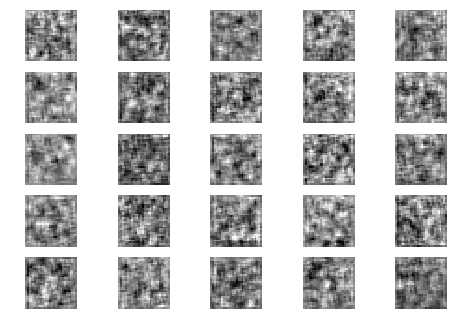

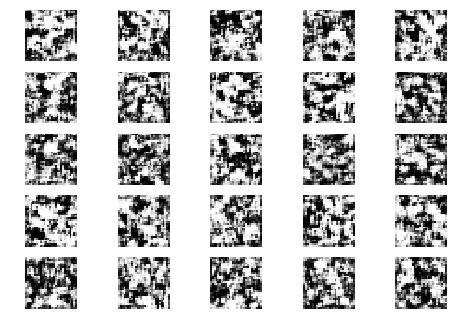

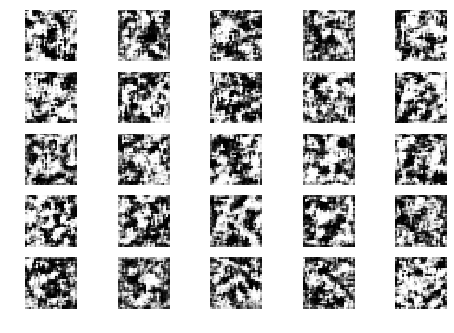

Epoch 0 Batch 1/937 [D loss: 0.588369, acc.: 71.88%] [G loss: 0.838591]
Epoch 0 Batch 2/937 [D loss: 0.699005, acc.: 59.38%] [G loss: 0.841357]
Epoch 0 Batch 3/937 [D loss: 0.458925, acc.: 84.38%] [G loss: 1.118056]
Epoch 0 Batch 4/937 [D loss: 0.443337, acc.: 84.38%] [G loss: 1.020184]
Epoch 0 Batch 5/937 [D loss: 0.391167, acc.: 81.25%] [G loss: 1.200273]
Epoch 0 Batch 6/937 [D loss: 0.425851, acc.: 78.12%] [G loss: 1.360677]
Epoch 0 Batch 7/937 [D loss: 0.483908, acc.: 71.88%] [G loss: 1.427846]
Epoch 0 Batch 8/937 [D loss: 0.420496, acc.: 78.12%] [G loss: 1.363683]
Epoch 0 Batch 9/937 [D loss: 0.488952, acc.: 81.25%] [G loss: 1.662857]
Epoch 0 Batch 10/937 [D loss: 0.570098, acc.: 68.75%] [G loss: 1.276299]
Epoch 0 Batch 11/937 [D loss: 0.385358, acc.: 87.50%] [G loss: 1.553005]
Epoch 0 Batch 12/937 [D loss: 0.345115, acc.: 84.38%] [G loss: 1.690642]
Epoch 0 Batch 13/937 [D loss: 0.415593, acc.: 87.50%] [G loss: 1.614090]
Epoch 0 Batch 14/937 [D loss: 0.397906, acc.: 81.25%] [G los

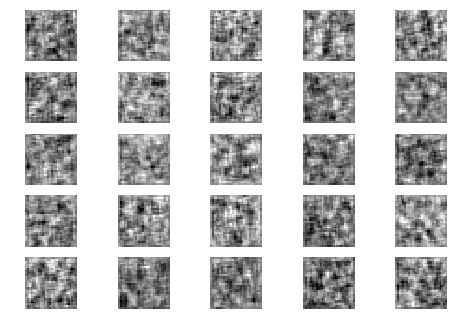

Epoch 0 Batch 101/937 [D loss: 0.457355, acc.: 81.25%] [G loss: 1.514925]


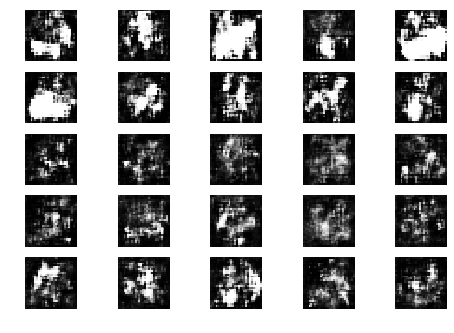

Epoch 0 Batch 102/937 [D loss: 0.624028, acc.: 71.88%] [G loss: 1.604146]


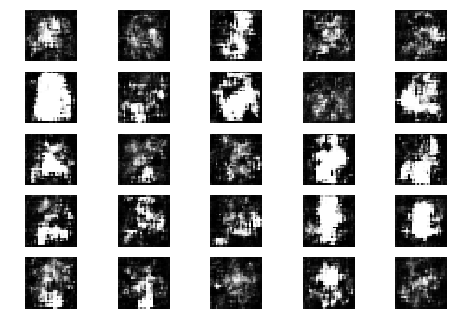

Epoch 0 Batch 103/937 [D loss: 0.496272, acc.: 78.12%] [G loss: 2.448229]
Epoch 0 Batch 104/937 [D loss: 0.544091, acc.: 78.12%] [G loss: 1.958826]
Epoch 0 Batch 105/937 [D loss: 0.752119, acc.: 59.38%] [G loss: 1.311256]
Epoch 0 Batch 106/937 [D loss: 0.344675, acc.: 87.50%] [G loss: 1.583001]
Epoch 0 Batch 107/937 [D loss: 0.384727, acc.: 75.00%] [G loss: 2.218238]
Epoch 0 Batch 108/937 [D loss: 0.869927, acc.: 56.25%] [G loss: 1.245557]
Epoch 0 Batch 109/937 [D loss: 0.789415, acc.: 53.12%] [G loss: 1.588262]
Epoch 0 Batch 110/937 [D loss: 0.774530, acc.: 71.88%] [G loss: 1.565698]
Epoch 0 Batch 111/937 [D loss: 0.377013, acc.: 87.50%] [G loss: 2.100635]
Epoch 0 Batch 112/937 [D loss: 0.561055, acc.: 78.12%] [G loss: 1.869653]
Epoch 0 Batch 113/937 [D loss: 0.749079, acc.: 62.50%] [G loss: 1.427249]
Epoch 0 Batch 114/937 [D loss: 0.445765, acc.: 78.12%] [G loss: 1.870292]
Epoch 0 Batch 115/937 [D loss: 0.502301, acc.: 75.00%] [G loss: 1.920181]
Epoch 0 Batch 116/937 [D loss: 0.48341

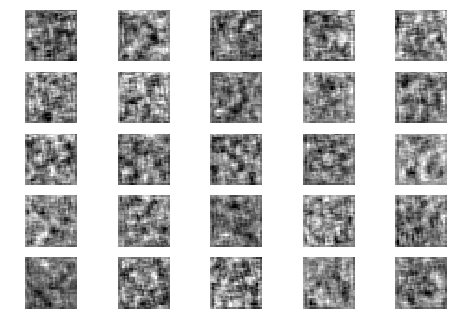

Epoch 0 Batch 201/937 [D loss: 0.679053, acc.: 65.62%] [G loss: 1.290563]
Epoch 0 Batch 202/937 [D loss: 0.488489, acc.: 75.00%] [G loss: 1.438135]


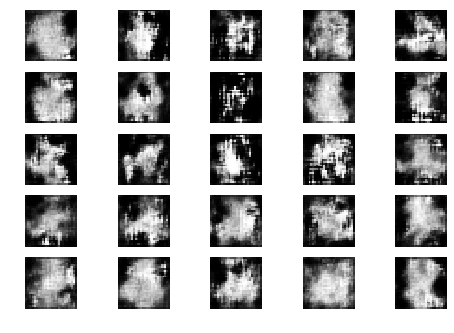

Epoch 0 Batch 203/937 [D loss: 1.115075, acc.: 46.88%] [G loss: 1.512763]
Epoch 0 Batch 204/937 [D loss: 0.612922, acc.: 71.88%] [G loss: 1.404377]


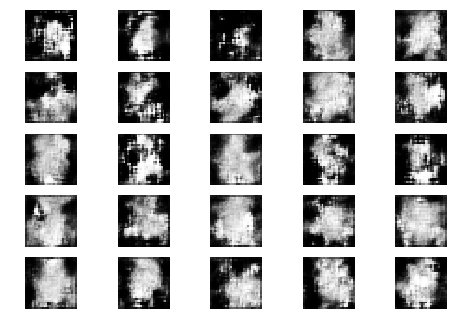

Epoch 0 Batch 205/937 [D loss: 0.620278, acc.: 71.88%] [G loss: 1.624096]
Epoch 0 Batch 206/937 [D loss: 0.633549, acc.: 78.12%] [G loss: 1.374520]
Epoch 0 Batch 207/937 [D loss: 0.648082, acc.: 65.62%] [G loss: 1.296136]
Epoch 0 Batch 208/937 [D loss: 0.787903, acc.: 59.38%] [G loss: 1.139998]
Epoch 0 Batch 209/937 [D loss: 0.467986, acc.: 84.38%] [G loss: 1.360461]
Epoch 0 Batch 210/937 [D loss: 0.738355, acc.: 65.62%] [G loss: 1.210830]
Epoch 0 Batch 211/937 [D loss: 0.597378, acc.: 59.38%] [G loss: 1.117395]
Epoch 0 Batch 212/937 [D loss: 0.784160, acc.: 62.50%] [G loss: 1.221292]
Epoch 0 Batch 213/937 [D loss: 0.590839, acc.: 62.50%] [G loss: 1.877246]
Epoch 0 Batch 214/937 [D loss: 0.814660, acc.: 56.25%] [G loss: 1.360065]
Epoch 0 Batch 215/937 [D loss: 0.652383, acc.: 71.88%] [G loss: 1.556737]
Epoch 0 Batch 216/937 [D loss: 0.555282, acc.: 71.88%] [G loss: 1.461262]
Epoch 0 Batch 217/937 [D loss: 0.742808, acc.: 59.38%] [G loss: 1.586575]
Epoch 0 Batch 218/937 [D loss: 0.71614

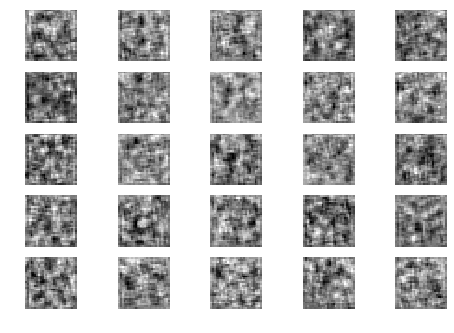

Epoch 0 Batch 301/937 [D loss: 0.538814, acc.: 71.88%] [G loss: 1.856560]
Epoch 0 Batch 302/937 [D loss: 0.748849, acc.: 62.50%] [G loss: 1.096242]
Epoch 0 Batch 303/937 [D loss: 0.563283, acc.: 68.75%] [G loss: 1.342204]


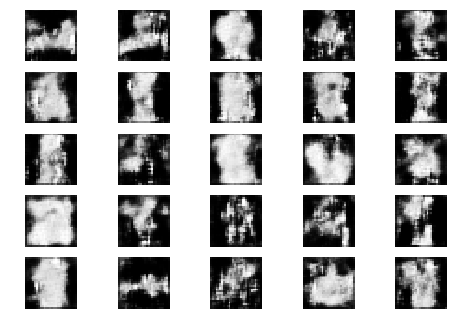

Epoch 0 Batch 304/937 [D loss: 0.514517, acc.: 78.12%] [G loss: 1.591603]
Epoch 0 Batch 305/937 [D loss: 0.678191, acc.: 65.62%] [G loss: 1.552708]
Epoch 0 Batch 306/937 [D loss: 0.663042, acc.: 62.50%] [G loss: 1.469136]


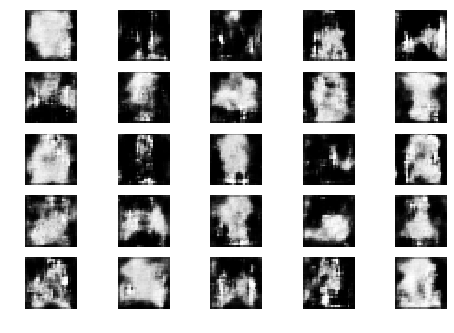

Epoch 0 Batch 307/937 [D loss: 0.523031, acc.: 71.88%] [G loss: 1.947076]
Epoch 0 Batch 308/937 [D loss: 0.563179, acc.: 71.88%] [G loss: 1.305073]
Epoch 0 Batch 309/937 [D loss: 0.733258, acc.: 56.25%] [G loss: 1.207924]
Epoch 0 Batch 310/937 [D loss: 0.610586, acc.: 71.88%] [G loss: 1.649599]
Epoch 0 Batch 311/937 [D loss: 0.572122, acc.: 65.62%] [G loss: 1.280895]
Epoch 0 Batch 312/937 [D loss: 0.406343, acc.: 90.62%] [G loss: 1.462400]
Epoch 0 Batch 313/937 [D loss: 0.641970, acc.: 62.50%] [G loss: 1.430537]
Epoch 0 Batch 314/937 [D loss: 0.741456, acc.: 68.75%] [G loss: 1.329866]
Epoch 0 Batch 315/937 [D loss: 0.897764, acc.: 53.12%] [G loss: 1.592570]
Epoch 0 Batch 316/937 [D loss: 0.682998, acc.: 59.38%] [G loss: 1.794743]
Epoch 0 Batch 317/937 [D loss: 0.744901, acc.: 65.62%] [G loss: 1.648138]
Epoch 0 Batch 318/937 [D loss: 0.492393, acc.: 81.25%] [G loss: 1.194363]
Epoch 0 Batch 319/937 [D loss: 0.630062, acc.: 65.62%] [G loss: 1.379674]
Epoch 0 Batch 320/937 [D loss: 0.63937

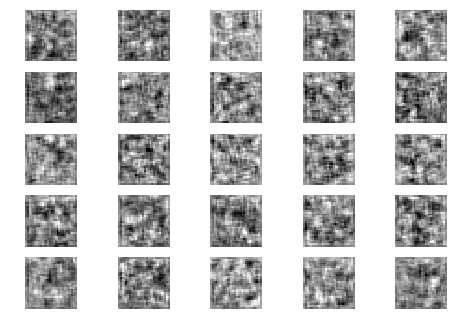

Epoch 0 Batch 401/937 [D loss: 0.618971, acc.: 75.00%] [G loss: 1.217901]
Epoch 0 Batch 402/937 [D loss: 0.532966, acc.: 81.25%] [G loss: 1.875029]
Epoch 0 Batch 403/937 [D loss: 0.540965, acc.: 78.12%] [G loss: 1.635972]
Epoch 0 Batch 404/937 [D loss: 0.442703, acc.: 81.25%] [G loss: 1.875144]


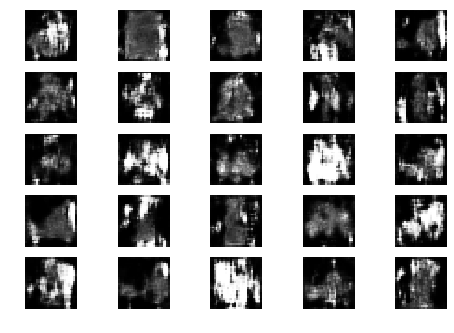

Epoch 0 Batch 405/937 [D loss: 0.442655, acc.: 71.88%] [G loss: 1.703774]
Epoch 0 Batch 406/937 [D loss: 0.698471, acc.: 71.88%] [G loss: 1.646174]
Epoch 0 Batch 407/937 [D loss: 0.559327, acc.: 65.62%] [G loss: 1.694405]
Epoch 0 Batch 408/937 [D loss: 0.746779, acc.: 68.75%] [G loss: 1.217504]


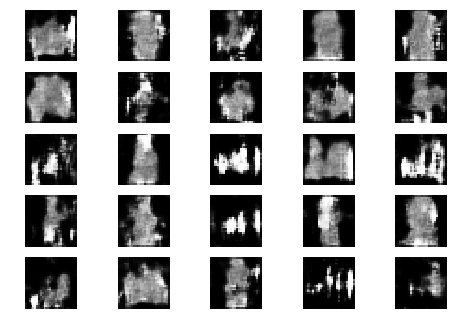

Epoch 0 Batch 409/937 [D loss: 0.531692, acc.: 71.88%] [G loss: 1.369419]
Epoch 0 Batch 410/937 [D loss: 0.470189, acc.: 78.12%] [G loss: 1.400952]
Epoch 0 Batch 411/937 [D loss: 0.634661, acc.: 68.75%] [G loss: 1.468677]
Epoch 0 Batch 412/937 [D loss: 0.736206, acc.: 62.50%] [G loss: 1.275440]
Epoch 0 Batch 413/937 [D loss: 0.719631, acc.: 62.50%] [G loss: 1.734796]
Epoch 0 Batch 414/937 [D loss: 0.779510, acc.: 56.25%] [G loss: 1.579539]
Epoch 0 Batch 415/937 [D loss: 0.757884, acc.: 56.25%] [G loss: 1.369411]
Epoch 0 Batch 416/937 [D loss: 0.586884, acc.: 68.75%] [G loss: 1.508256]
Epoch 0 Batch 417/937 [D loss: 0.658144, acc.: 59.38%] [G loss: 1.416162]
Epoch 0 Batch 418/937 [D loss: 0.432514, acc.: 87.50%] [G loss: 1.514591]
Epoch 0 Batch 419/937 [D loss: 0.617468, acc.: 65.62%] [G loss: 1.627902]
Epoch 0 Batch 420/937 [D loss: 0.729831, acc.: 62.50%] [G loss: 1.682499]
Epoch 0 Batch 421/937 [D loss: 0.616542, acc.: 62.50%] [G loss: 1.466142]
Epoch 0 Batch 422/937 [D loss: 0.47544

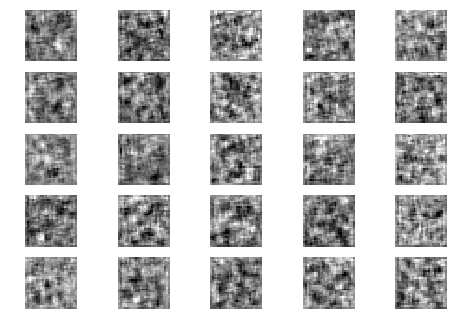

Epoch 0 Batch 501/937 [D loss: 0.566066, acc.: 71.88%] [G loss: 1.814046]
Epoch 0 Batch 502/937 [D loss: 0.613231, acc.: 59.38%] [G loss: 1.755295]
Epoch 0 Batch 503/937 [D loss: 0.827270, acc.: 46.88%] [G loss: 1.132090]
Epoch 0 Batch 504/937 [D loss: 0.557767, acc.: 75.00%] [G loss: 1.707203]
Epoch 0 Batch 505/937 [D loss: 0.497353, acc.: 71.88%] [G loss: 1.309958]


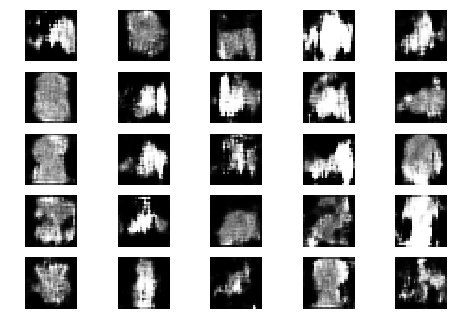

Epoch 0 Batch 506/937 [D loss: 0.765056, acc.: 56.25%] [G loss: 1.141186]
Epoch 0 Batch 507/937 [D loss: 0.646666, acc.: 62.50%] [G loss: 1.369691]
Epoch 0 Batch 508/937 [D loss: 0.833274, acc.: 46.88%] [G loss: 1.432532]
Epoch 0 Batch 509/937 [D loss: 0.680914, acc.: 62.50%] [G loss: 1.710428]
Epoch 0 Batch 510/937 [D loss: 0.603801, acc.: 65.62%] [G loss: 1.480521]


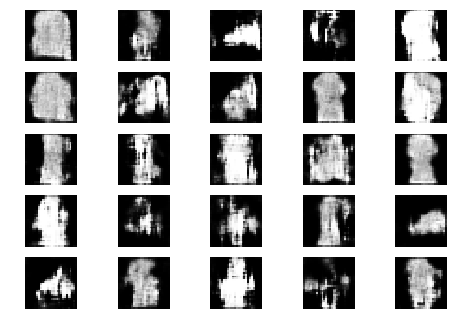

Epoch 0 Batch 511/937 [D loss: 0.687533, acc.: 59.38%] [G loss: 1.341914]
Epoch 0 Batch 512/937 [D loss: 0.671035, acc.: 62.50%] [G loss: 1.219600]
Epoch 0 Batch 513/937 [D loss: 0.615837, acc.: 75.00%] [G loss: 1.480175]
Epoch 0 Batch 514/937 [D loss: 0.576011, acc.: 71.88%] [G loss: 1.055517]
Epoch 0 Batch 515/937 [D loss: 0.456260, acc.: 71.88%] [G loss: 1.696093]
Epoch 0 Batch 516/937 [D loss: 0.641511, acc.: 59.38%] [G loss: 1.538875]
Epoch 0 Batch 517/937 [D loss: 0.582048, acc.: 78.12%] [G loss: 1.827105]
Epoch 0 Batch 518/937 [D loss: 0.439872, acc.: 75.00%] [G loss: 1.912884]
Epoch 0 Batch 519/937 [D loss: 0.721338, acc.: 59.38%] [G loss: 1.491919]
Epoch 0 Batch 520/937 [D loss: 0.880153, acc.: 59.38%] [G loss: 1.352972]
Epoch 0 Batch 521/937 [D loss: 0.584681, acc.: 75.00%] [G loss: 1.369426]
Epoch 0 Batch 522/937 [D loss: 0.468869, acc.: 78.12%] [G loss: 1.475502]
Epoch 0 Batch 523/937 [D loss: 0.813896, acc.: 53.12%] [G loss: 1.047907]
Epoch 0 Batch 524/937 [D loss: 0.63202

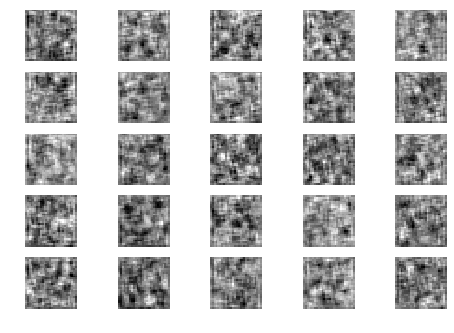

Epoch 0 Batch 601/937 [D loss: 0.834459, acc.: 53.12%] [G loss: 1.260399]
Epoch 0 Batch 602/937 [D loss: 0.802259, acc.: 56.25%] [G loss: 1.214737]
Epoch 0 Batch 603/937 [D loss: 0.529236, acc.: 75.00%] [G loss: 1.202424]
Epoch 0 Batch 604/937 [D loss: 0.545335, acc.: 78.12%] [G loss: 1.301862]
Epoch 0 Batch 605/937 [D loss: 0.573119, acc.: 71.88%] [G loss: 1.323401]
Epoch 0 Batch 606/937 [D loss: 0.601731, acc.: 68.75%] [G loss: 1.107464]


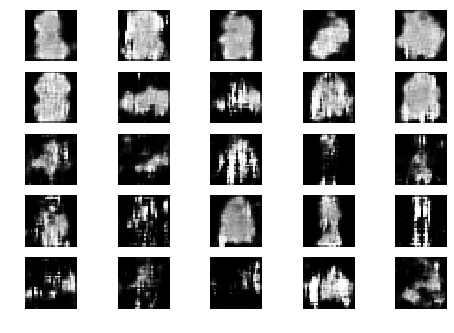

Epoch 0 Batch 607/937 [D loss: 0.804232, acc.: 62.50%] [G loss: 1.285591]
Epoch 0 Batch 608/937 [D loss: 0.442874, acc.: 71.88%] [G loss: 1.453471]
Epoch 0 Batch 609/937 [D loss: 0.683770, acc.: 71.88%] [G loss: 1.539546]
Epoch 0 Batch 610/937 [D loss: 0.524072, acc.: 84.38%] [G loss: 1.349440]
Epoch 0 Batch 611/937 [D loss: 0.733107, acc.: 62.50%] [G loss: 1.167804]
Epoch 0 Batch 612/937 [D loss: 0.448041, acc.: 71.88%] [G loss: 1.191048]


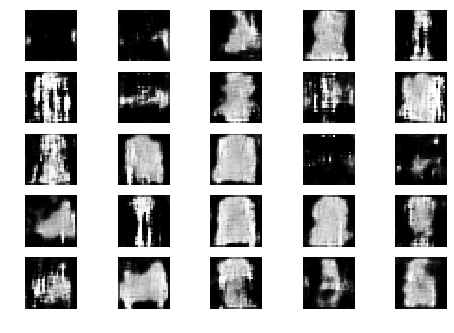

Epoch 0 Batch 613/937 [D loss: 0.505543, acc.: 68.75%] [G loss: 1.455854]
Epoch 0 Batch 614/937 [D loss: 0.651516, acc.: 59.38%] [G loss: 1.359505]
Epoch 0 Batch 615/937 [D loss: 0.615683, acc.: 75.00%] [G loss: 1.062402]
Epoch 0 Batch 616/937 [D loss: 0.572850, acc.: 75.00%] [G loss: 1.208589]
Epoch 0 Batch 617/937 [D loss: 0.425749, acc.: 78.12%] [G loss: 1.506011]
Epoch 0 Batch 618/937 [D loss: 0.776732, acc.: 46.88%] [G loss: 1.101479]
Epoch 0 Batch 619/937 [D loss: 0.525856, acc.: 78.12%] [G loss: 1.425950]
Epoch 0 Batch 620/937 [D loss: 0.460649, acc.: 78.12%] [G loss: 1.361830]
Epoch 0 Batch 621/937 [D loss: 0.489306, acc.: 81.25%] [G loss: 1.508850]
Epoch 0 Batch 622/937 [D loss: 0.681459, acc.: 53.12%] [G loss: 1.220739]
Epoch 0 Batch 623/937 [D loss: 0.603780, acc.: 75.00%] [G loss: 1.495844]
Epoch 0 Batch 624/937 [D loss: 0.801392, acc.: 56.25%] [G loss: 1.279550]
Epoch 0 Batch 625/937 [D loss: 0.573163, acc.: 65.62%] [G loss: 1.377834]
Epoch 0 Batch 626/937 [D loss: 0.52063

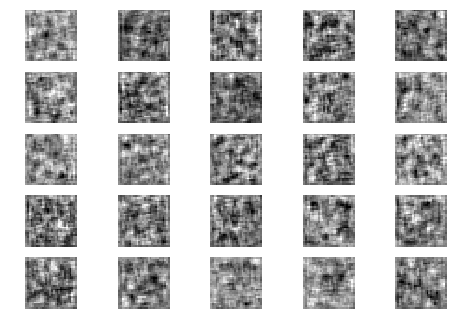

Epoch 0 Batch 701/937 [D loss: 0.920200, acc.: 46.88%] [G loss: 1.493452]
Epoch 0 Batch 702/937 [D loss: 0.608031, acc.: 65.62%] [G loss: 1.838216]
Epoch 0 Batch 703/937 [D loss: 0.483534, acc.: 75.00%] [G loss: 1.495038]
Epoch 0 Batch 704/937 [D loss: 0.541853, acc.: 68.75%] [G loss: 1.425280]
Epoch 0 Batch 705/937 [D loss: 0.722663, acc.: 62.50%] [G loss: 1.385527]
Epoch 0 Batch 706/937 [D loss: 0.583560, acc.: 78.12%] [G loss: 1.389534]
Epoch 0 Batch 707/937 [D loss: 0.709988, acc.: 62.50%] [G loss: 1.446904]


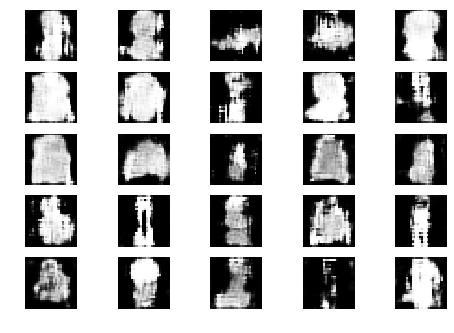

Epoch 0 Batch 708/937 [D loss: 0.697490, acc.: 59.38%] [G loss: 1.554429]
Epoch 0 Batch 709/937 [D loss: 0.618322, acc.: 68.75%] [G loss: 1.841342]
Epoch 0 Batch 710/937 [D loss: 0.605917, acc.: 71.88%] [G loss: 1.537581]
Epoch 0 Batch 711/937 [D loss: 0.569744, acc.: 71.88%] [G loss: 1.426936]
Epoch 0 Batch 712/937 [D loss: 0.581387, acc.: 68.75%] [G loss: 1.880986]
Epoch 0 Batch 713/937 [D loss: 0.527807, acc.: 62.50%] [G loss: 1.780693]
Epoch 0 Batch 714/937 [D loss: 0.542053, acc.: 68.75%] [G loss: 1.259952]


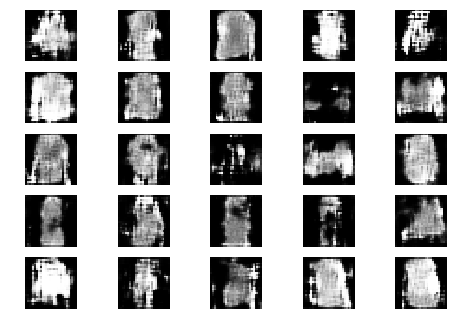

Epoch 0 Batch 715/937 [D loss: 0.630068, acc.: 68.75%] [G loss: 1.627067]
Epoch 0 Batch 716/937 [D loss: 0.584053, acc.: 78.12%] [G loss: 1.618496]
Epoch 0 Batch 717/937 [D loss: 0.376356, acc.: 81.25%] [G loss: 1.533281]
Epoch 0 Batch 718/937 [D loss: 0.763652, acc.: 62.50%] [G loss: 1.755465]
Epoch 0 Batch 719/937 [D loss: 0.746826, acc.: 65.62%] [G loss: 1.056177]
Epoch 0 Batch 720/937 [D loss: 0.714272, acc.: 53.12%] [G loss: 1.263460]
Epoch 0 Batch 721/937 [D loss: 0.562421, acc.: 65.62%] [G loss: 1.250171]
Epoch 0 Batch 722/937 [D loss: 0.668722, acc.: 65.62%] [G loss: 1.253102]
Epoch 0 Batch 723/937 [D loss: 0.723897, acc.: 62.50%] [G loss: 1.536463]
Epoch 0 Batch 724/937 [D loss: 0.472785, acc.: 81.25%] [G loss: 1.486538]
Epoch 0 Batch 725/937 [D loss: 0.616937, acc.: 62.50%] [G loss: 1.585986]
Epoch 0 Batch 726/937 [D loss: 0.536861, acc.: 71.88%] [G loss: 1.547161]
Epoch 0 Batch 727/937 [D loss: 0.768354, acc.: 71.88%] [G loss: 1.373702]
Epoch 0 Batch 728/937 [D loss: 0.49240

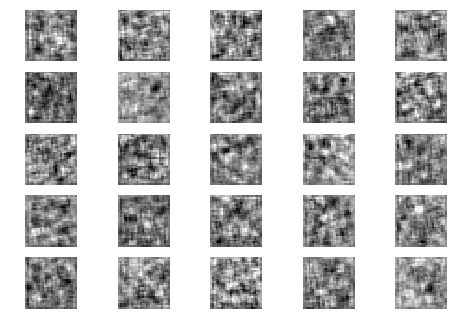

Epoch 0 Batch 801/937 [D loss: 0.572611, acc.: 68.75%] [G loss: 1.638067]
Epoch 0 Batch 802/937 [D loss: 0.511925, acc.: 71.88%] [G loss: 1.713701]
Epoch 0 Batch 803/937 [D loss: 0.484515, acc.: 78.12%] [G loss: 1.737376]
Epoch 0 Batch 804/937 [D loss: 0.527645, acc.: 68.75%] [G loss: 1.757826]
Epoch 0 Batch 805/937 [D loss: 0.660582, acc.: 59.38%] [G loss: 1.745368]
Epoch 0 Batch 806/937 [D loss: 0.888643, acc.: 50.00%] [G loss: 1.550941]
Epoch 0 Batch 807/937 [D loss: 0.686511, acc.: 62.50%] [G loss: 1.660459]


In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=20, modeltotrain=2)

In [0]:
!rm -rf generator2fmnist.h5


In [0]:

generator2.save('generator2fmnist.h5')

In [26]:
!ls -al


total 97520
drwxr-xr-x 1 root root     4096 Dec  5 13:25 .
drwxr-xr-x 1 root root     4096 Dec  5 05:42 ..
-rw-r--r-- 1 root root 22256168 Dec  5 08:34 combined1.h5
drwxr-xr-x 1 root root     4096 Dec  3 17:43 .config
-rw-r--r-- 1 root root 15348832 Dec  5 08:34 discriminator1.h5
-rw-r--r-- 1 root root 10336800 Dec  5 12:12 generator1fminst2.h5
-rw-r--r-- 1 root root 10336816 Dec  5 13:27 generator1fminst.h5
-rw-r--r-- 1 root root    55406 Dec  5 09:40 generator1.h5
-rw-r--r-- 1 root root    55407 Dec  5 08:35 generator1.h5.1
-rw-r--r-- 1 root root 10336800 Dec  5 08:35 generator1.h5.2
-rw-r--r-- 1 root root 10336824 Dec  5 12:26 generator2fmnist.h5
-rw-r--r-- 1 root root 10336800 Dec  5 09:05 generatorTrained1.h5
-rw-r--r-- 1 root root 10336800 Dec  5 10:25 generatorTrainedepoch2git.h5
-rw-r--r-- 1 root root    33975 Dec  5 13:24 model.png
-rw-r--r-- 1 root root    33975 Dec  5 13:25 modelsmall.png
drwxr-xr-x 2 root root     4096 Dec  3 17:43 sample_data


In [0]:
!ls -al

In [0]:
##!wget https://github.com/rajagopalmotivate/try1/raw/master/generatorTrainedepoch2git.h5

In [0]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNEW( averagemode = 3 ,  loadpretrainedweights=True)


In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=1)

In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=2)

In [0]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNEW( averagemode = 3 ,  loadpretrainedweights=True)


In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=3)

In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=3)

In [0]:
plotamodel(combined)
files.download('model.png')

In [0]:
!rm -rf generatorTrainedepoch2.h5

generator1.save('generator1fminst.h5')

!rm -rf generator2Trainedepoch2.h5

generator2.save('generator2fminst.h5')


In [0]:
generator1 = generator1.load_weights('generator1fmnist.h5')

In [0]:
generator2 = generator2.load_weights('generator2fmnist.h5')

In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1)

In [0]:
generator1.save('generatorTrained1epoch4.h5')

In [22]:
files.download('generator1fmnist.h5')

FileNotFoundError: ignored

In [0]:
files.download('generator2fmnist.h5')

In [0]:
##files.download('discriminator1.h5')

In [0]:
##files.download('combined1.h5')

In [0]:
#generator1 = load_model('generator1.h5')
#discriminator1 = load_model('discriminator1.h5')
#combined1 = load_model('combined1.h5')

